__Purpose:__ Introduce Federated Learning, specifically by implementing FedAveraging on our dataset and moving on to more advanced methods.  Start by modifying the Simulations code, worry about (a)synchronicity later.
<br>
1. We are assuming we can test on the second half (updates 10-19ish) since (human/co-adaptive) learning should be complete by then!  For reasons shown in earlier NBs

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

In [2]:
from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [3]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# Reminder of Conditions Order

NOTE: 

* **CONDITIONS** = array(['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7','D_8']
* **LEARNING RATES:** alpha = 0.25 and 0.75; alpha = 0.25 for D1, D2, D5, D6; alpha = 0.75 for D3, D4, D7, D8
* **SMOOTHBATCH:** W_next = alpha*W_old + ((1 - alpha) * W_calc)

* **DECODER INIT:** pos for D1 - D4, neg for D5 - D8

* **PENALTY TERM:** $\lambda_E$ = 1e-6 for all, $\lambda_F$ = 1e-7 for all, $\lambda_D$ = 1e-3 for 1, 3, 5, 7 and 1e-4 for 2, 4, 6, 8 


| DECODER | ALPHA | PENALTY | DEC INIT |
| --- | --- | --- | --- |
| 1 | 0.25 | 1e-3 | + |
| 2 | 0.25 | 1e-4 | + |
| 3 | 0.75 | 1e-3 | + |
| 4 | 0.75 | 1e-4 | + |
| 5 | 0.25 | 1e-3 | - |
| 6 | 0.25 | 1e-4 | - |
| 7 | 0.75 | 1e-3 | - |
| 8 | 0.75 | 1e-4 | - |


# Create Federated Set Up

In [4]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

#pca = PCA(n_components=7)
#new_dec = pca.fit_transform(cond0_init_decs[0])
#print(new_dec.shape)
# Can't do this since 7 < min (2, 64)...

In [5]:
D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

> __Passing in init decoders that are not (2, PCA_comps) AKA (2, 7) will result in the passed in dec getting overwritten to prevent matrix size mismatches.  Can't pass in the init dec from CPHS now because of PCA (unless you turn PCA off of course)__.

Check streaming condition

In [6]:
user_c0_etascipy_streaming = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0) for i in range(14)]
global_model = Server(-100, D_0_7, 'FedAvg', user_c0_etascipy_streaming)
global_model.execute_FL_loop()
global_model.execute_FL_loop()

Check full data condition

In [7]:
user_c0_etascipy_full = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'full_data', delay_scaling=0) for i in range(14)]
global_model = Server(-101, D_0_7, 'FedAvg', user_c0_etascipy_full)
global_model.execute_FL_loop()
global_model.execute_FL_loop()

Check advance_each_iter condition

In [8]:
user_c0_etascipy_advance = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model = Server(-102, D_0_7, 'FedAvg', user_c0_etascipy_advance)
global_model.execute_FL_loop()
global_model.execute_FL_loop()

Check the non-PCA case now... this is no longer the default
> This one should overwrite

In [9]:
user_c0_etascipy_streaming = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model = Server(-103, D_0_7, 'FedAvg', user_c0_etascipy_streaming, PCA_comps=64)

global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
print()
print("Global Error Log")
print(global_model.global_error_log)
print()
print("Local Error Log")
print(global_model.local_error_log)
print()
print("Confirmation that no PCA happened (size should be 64)")
print(user_c0_etascipy_streaming[0].w.shape)
print(user_c0_etascipy_streaming[0].w_prev.shape)

Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decoder: (2, 7) --> (2, 64)
Class BaseModel: Overwrote the provided init decode

## Double Checking Running the No-FL Case
> We should see some kind of convergence
> TURNING PCA OFF FOR THIS CASE SINCE SIMS DID NOT HAVE IT

In [10]:
user_c0_fullscipy = [Client(i, D_0, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl = Server(-1, D_0, 'NoFL', user_c0_fullscipy, PCA_comps=64)
print(f"Global Round: {global_model_no_fl.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy[0].current_round}")
print(f"Local Update: {user_c0_fullscipy[0].current_update}")

Global Round: 0

Local Round: 0
Local Update: 0


In [11]:
global_model_no_fl.execute_FL_loop()

print(f"Global Round: {global_model_no_fl.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy[0].current_round}")
print(f"Local Update: {user_c0_fullscipy[0].current_update}")

Global Round: 1

Local Round: 1
Local Update: 1


In [12]:
# We are at update 2/19.  Therefore 19-2=17-1=16
num_updates_left = 16
for i in range(num_updates_left):
    if i%np.ceil(num_updates_left*.1)==0:
        print(f"Iter {i}")
    global_model_no_fl.execute_FL_loop()
print("Complete")
print()
print()
print()
print(f"Global Round: {global_model_no_fl.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy[0].current_round}")
print(f"Local Update: {user_c0_fullscipy[0].current_update}")

Iter 0
Iter 2
Iter 4
Iter 6
Iter 8
Iter 10
Iter 12
Iter 14
Complete



Global Round: 17

Local Round: 17
Local Update: 17


In [13]:
print(user_c0_fullscipy[0].current_round)
print(user_c0_fullscipy[0].current_update)

17
17


Check the performance... should approximately mirror the previous NB, or at least show that error is decreasing...
> (3: darkorange), (13: deeppink), (1: maroon)

In [14]:
cost_array = np.zeros((num_participants,17))

for i in range(17):
    for (client_id, error) in global_model_no_fl.local_error_log[i]:
        cost_array[client_id, i] = error

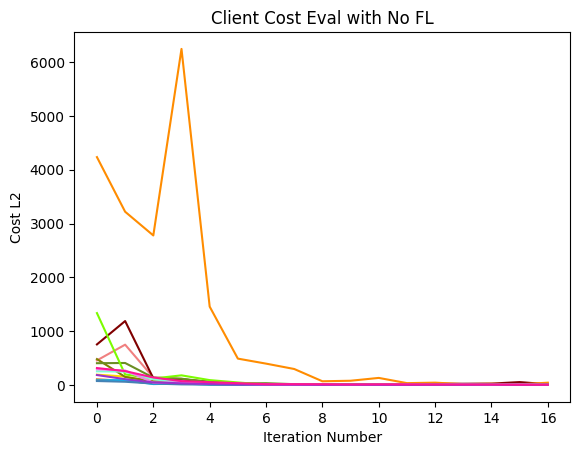

In [15]:
step_indices = list(range(17))
for i in range(num_participants):
    plt.plot(step_indices, cost_array[i, :], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Client Cost Eval with No FL')
plt.show()

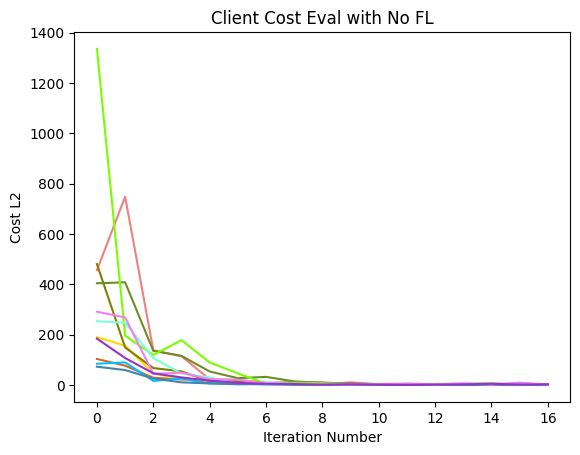

In [16]:
for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        plt.plot(step_indices, cost_array[i, :], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Client Cost Eval with No FL')
#plt.ylim(0, 20)
plt.show()

Save Decs to compare to sims

In [17]:
all_user_decs_no_fl = [user_c0_fullscipy[i].dec_log for i in range(num_participants)]

#with open(path+nofl_decs_filename, 'wb') as fp:
#    pickle.dump(all_user_decs_no_fl, fp, protocol=pickle.HIGHEST_PROTOCOL)

Retry but now use the init decs that we loaded in instead of the random inits

In [18]:
#user_c0_fullscipy = [Client(i, D_0, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', PCA_comps=64, delay_scaling=0) for i in range(14)]
#global_model_no_fl = Server(-1, D_0, 'NoFL', user_c0_fullscipy, PCA_comps=64)
user_c0_fullscipy_winit = [Client(i, cond0_init_decs[i], 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl_winit = Server(-1, D_0, 'NoFL', user_c0_fullscipy_winit, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    if i%5==0:
        print(f"Iter {i}")
    global_model_no_fl_winit.execute_FL_loop()
print("Complete")
print()
print()
print()
print(f"Global Round: {global_model_no_fl_winit.current_round}")
print()
print(f"Local Round: {user_c0_fullscipy_winit[0].current_round}")
print(f"Local Update: {user_c0_fullscipy_winit[0].current_update}")

Iter 0
Iter 5
Iter 10
Iter 15
Complete



Global Round: 18

Local Round: 18
Local Update: 17


In [19]:
cost_array_winit = np.zeros((num_participants,17))

for i in range(17):
    for (client_id, error) in global_model_no_fl_winit.local_error_log[i]:
        #plt.scatter(i, error, color=id2color[client_id])
        cost_array_winit[client_id, i] = error

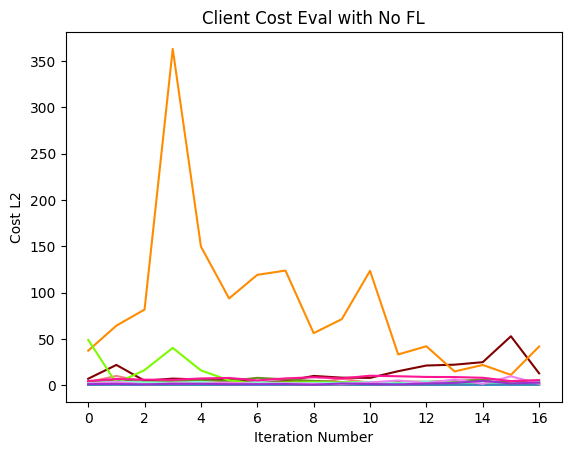

In [20]:
step_indices = list(range(17))
for i in range(num_participants):
    plt.plot(step_indices, cost_array_winit[i, :], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Client Cost Eval with No FL')
plt.show()

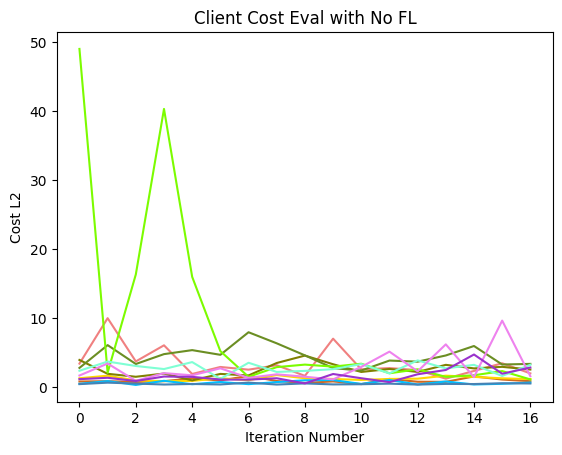

In [21]:
for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        plt.plot(step_indices, cost_array_winit[i, :], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Client Cost Eval with No FL')
#plt.ylim(0, 20)
plt.show()

## 1 Scipy Step, 1000 Iterations

In [22]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 2000
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model_1scipystep.execute_FL_loop()
print("Complete")

Iter 0
Iter 200
Client 1: New update after lrt passed: (new update, current round): (11, 50)

Iter 400
Iter 600
Client 1: New update after lrt passed: (new update, current round): (12, 100)

Iter 800
Iter 1000
Client 1: New update after lrt passed: (new update, current round): (13, 150)

Iter 1200
Iter 1400
Client 1: New update after lrt passed: (new update, current round): (14, 200)

Iter 1600
Client 1: New update after lrt passed: (new update, current round): (15, 250)

Iter 1800
Complete


In [23]:
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))

(Current Local Round, Current Local Update)
(284, 15)
(283, 15)
(267, 15)
(328, 16)
(292, 15)
(268, 15)
(302, 16)
(264, 15)
(295, 15)
(291, 15)
(288, 15)
(295, 15)
(255, 15)
(288, 15)


Local

Iter 0
Iter 200
Iter 400
Iter 600
Iter 800
Iter 1000
Iter 1200
Iter 1400
Iter 1600
Iter 1800


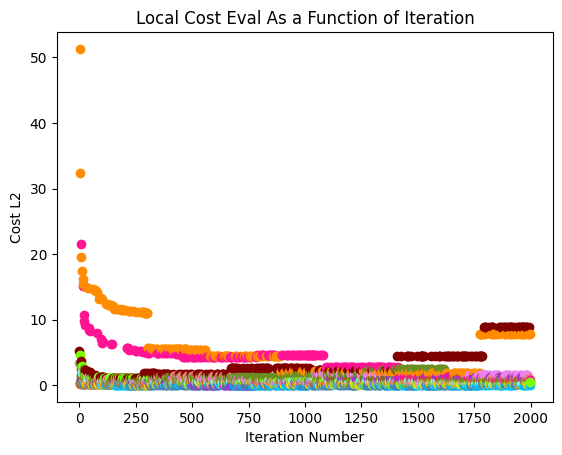

In [24]:
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    for (client_id, error) in global_model_1scipystep.local_error_log[i]:
        plt.scatter(i, error, color=id2color[client_id])
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
#plt.ylim(0, 10)
plt.show()

Global

Iter 0
Iter 200
Iter 400
Iter 600
Iter 800
Iter 1000
Iter 1200
Iter 1400
Iter 1600
Iter 1800


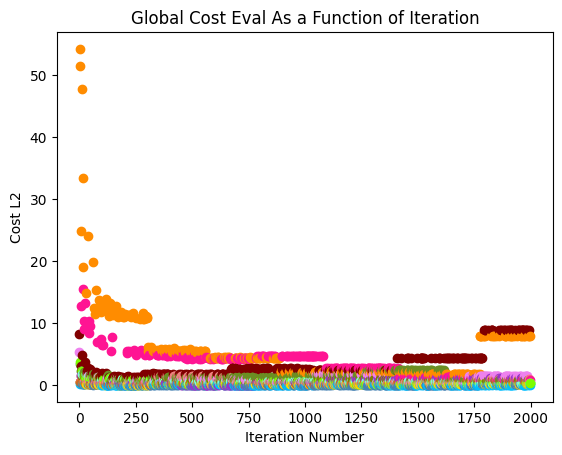

In [25]:
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    for (client_id, error) in global_model_1scipystep.global_error_log[i]:
        plt.scatter(i, error, color=id2color[client_id])
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Global Cost Eval As a Function of Iteration')
#plt.ylim(0, 10)
plt.show()

__Redoing but setting the local threshold for update to be much lower__

In [26]:
reduced_limit = 50

In [27]:
user_c0_1ScipyStep_lim50 = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_lim50 = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_lim50)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model_1scipystep_lim50.execute_FL_loop()
print("Complete")

Iter 0
Iter 200
Iter 400
Client 1: New update after lrt passed: (new update, current round): (11, 50)

Iter 600
Client 1: New update after lrt passed: (new update, current round): (12, 100)

Iter 800
Iter 1000
Client 1: New update after lrt passed: (new update, current round): (13, 150)

Iter 1200
Iter 1400
Client 1: New update after lrt passed: (new update, current round): (14, 200)

Iter 1600
Client 1: New update after lrt passed: (new update, current round): (15, 250)

Iter 1800
Complete


Local

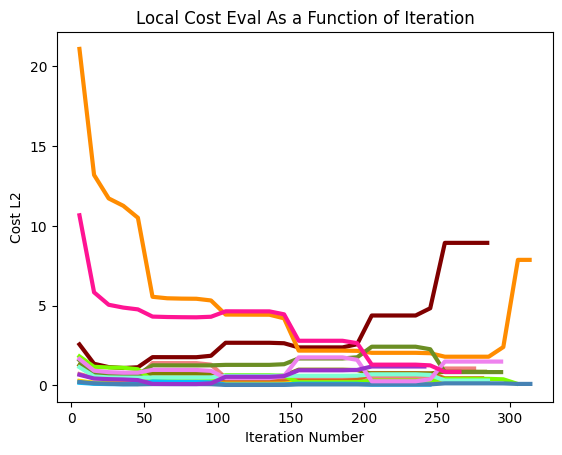

In [28]:
dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_1ScipyStep_lim50[i].local_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
plt.show()

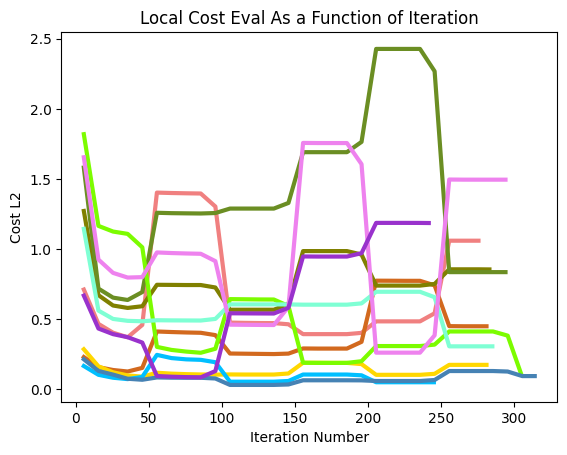

In [29]:
dim_reduc_factor = 10

for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        df = pd.DataFrame(user_c0_1ScipyStep_lim50[i].local_error_log)
        df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
        plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
plt.show()

> From earlier run... not sure what changed... 
__Final update cost goes down__
1. 3 darkorange
1. 4 gold
1. 5 olive
1. 6 olivedrab, hardly
1. 7 lawngreen
1. 8 aquamarine
1. 9 deepskyblue
1. 11 violet
<br> <br> 
__Final update cost goes up__
1. 0 lightcoral
1. 1 maroon 
1. 2 chocolate
1. 10 steelblue
1. 12 darkorchid
1. 13 deeppink

Global

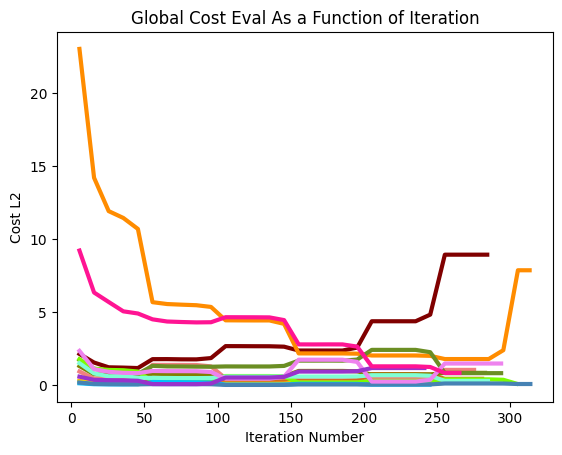

In [30]:
dim_reduc_factor = 10

for i in range(num_participants):
    df = pd.DataFrame(user_c0_1ScipyStep_lim50[i].global_error_log)
    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Global Cost Eval As a Function of Iteration')
plt.show()

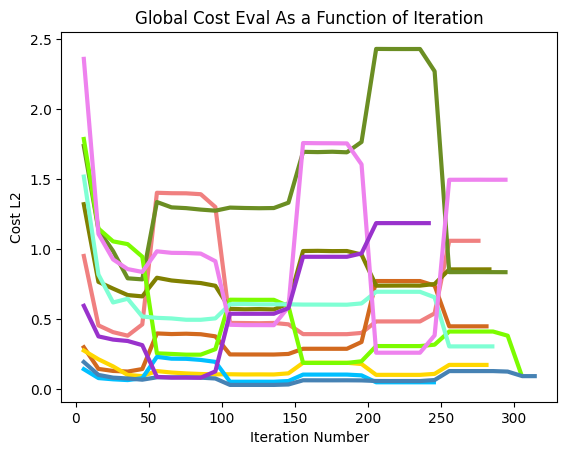

In [31]:
dim_reduc_factor = 10

for i in range(num_participants):
    if i in (1, 3, 13):
        pass
    else:
        df = pd.DataFrame(user_c0_1ScipyStep_lim50[i].global_error_log)
        df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
        plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Global Cost Eval As a Function of Iteration')
plt.show()

This time, use the final global model as the init instead of a random init
> Compare against using the local model? Doesn't help for new clients...

In [32]:
global_model_1scipystep_lim50.w

array([[ 3.21976259e-03,  6.54792171e-04,  5.31160791e-04,
         1.82296877e-03,  1.19960207e-03,  5.87155513e-03,
         6.80484807e-03],
       [-5.18668168e-05,  6.52024933e-04,  6.70617342e-04,
         1.08841513e-03, -1.65624488e-03, -5.06518538e-04,
         2.56792876e-03]])

In [33]:
user_c0_1ScipyStep_globaldec = [Client(i, global_model_1scipystep_lim50.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_globaldecinit = Server(1, global_model_1scipystep_lim50.w, 'FedAvg', user_c0_1ScipyStep_globaldec)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model_globaldecinit.execute_FL_loop()
print("Complete")

Iter 0
Iter 200
Client 1: New update after lrt passed: (new update, current round): (11, 50)

Iter 400
Iter 600
Client 1: New update after lrt passed: (new update, current round): (12, 100)

Iter 800
Iter 1000
Client 1: New update after lrt passed: (new update, current round): (13, 150)

Iter 1200
Client 1: New update after lrt passed: (new update, current round): (14, 200)

Iter 1400
Iter 1600
Client 1: New update after lrt passed: (new update, current round): (15, 250)

Iter 1800
Complete


In [34]:
for my_client in global_model_globaldecinit.all_clients:
    print((my_client.current_round, my_client.current_update))

(285, 15)
(297, 15)
(270, 15)
(293, 15)
(253, 15)
(285, 15)
(304, 16)
(283, 15)
(306, 16)
(271, 15)
(298, 15)
(280, 15)
(280, 15)
(295, 15)


## Why are the local and global error logs the exact same here.  This is the only case where this happens I think

Local

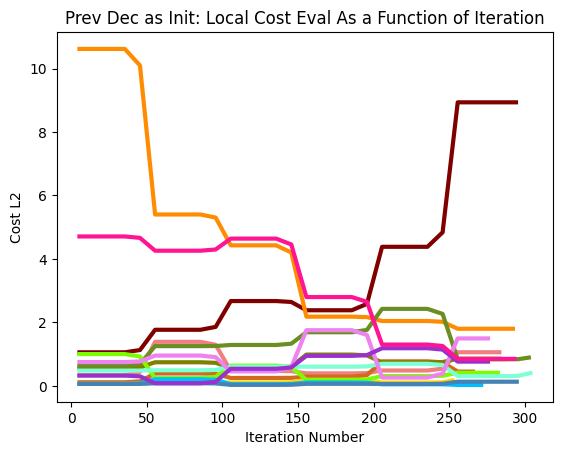

In [35]:
dim_reduc_factor = 10

for i in range(num_participants):
    #if i in (1, 3, 13):
    #    pass
    #else:
    df_local_log = pd.DataFrame(user_c0_1ScipyStep_globaldec[i].local_error_log)
    df_local_log10 = df_local_log.groupby(df_local_log.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df_local_log10.values[:, 0], df_local_log10.values[:, 1], color=id2color[i], linewidth=3)

plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Prev Dec as Init: Local Cost Eval As a Function of Iteration')
plt.show()

Global

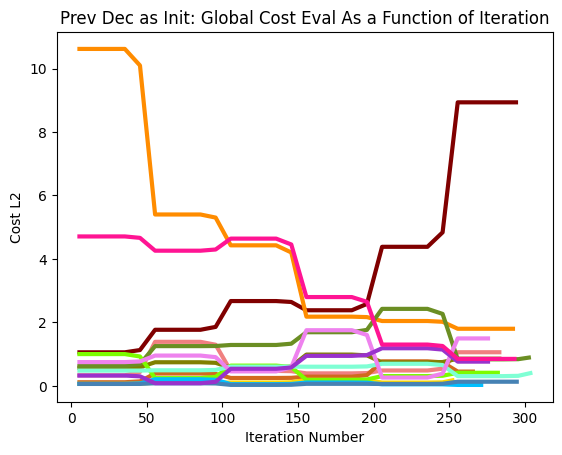

In [36]:
dim_reduc_factor = 10

for i in range(num_participants):
    #if i in (1, 3, 13):
    #    pass
    #else:
    df_global_error = pd.DataFrame(user_c0_1ScipyStep_globaldec[i].global_error_log)
    df_global_error10 = df_global_error.groupby(df_global_error.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df_global_error10.values[:, 0], df_global_error10.values[:, 1], color=id2color[i], linewidth=3)

plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Prev Dec as Init: Global Cost Eval As a Function of Iteration')
plt.show()

I can't tell much difference between the sets of plots, using the Previous Global Dec as the init...

## 10 Steps

In [37]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvg', user_c0_10scipy)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model_10scipy.execute_FL_loop()
print("Complete")

Iter 0
Iter 200
Iter 400
Iter 600
Iter 800
Iter 1000
Iter 1200
Iter 1400
Iter 1600
Iter 1800
Complete


In [38]:
for my_client in global_model_globaldecinit.all_clients:
    print((my_client.current_round, my_client.current_update))

(285, 15)
(297, 15)
(270, 15)
(293, 15)
(253, 15)
(285, 15)
(304, 16)
(283, 15)
(306, 16)
(271, 15)
(298, 15)
(280, 15)
(280, 15)
(295, 15)


Local

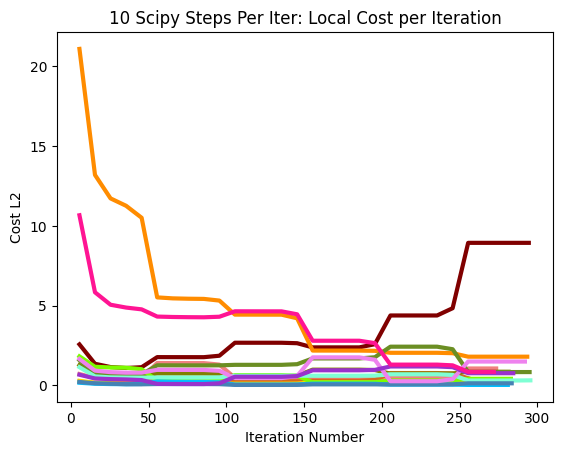

In [39]:
dim_reduc_factor = 10

for i in range(num_participants):
    #if i in (1, 3, 13):
    #    pass
    #else:
    df_local_log = pd.DataFrame(user_c0_10scipy[i].local_error_log)
    df_local_log10 = df_local_log.groupby(df_local_log.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df_local_log10.values[:, 0], df_local_log10.values[:, 1], color=id2color[i], linewidth=3)

plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('10 Scipy Steps Per Iter: Local Cost per Iteration')
plt.show()

Global

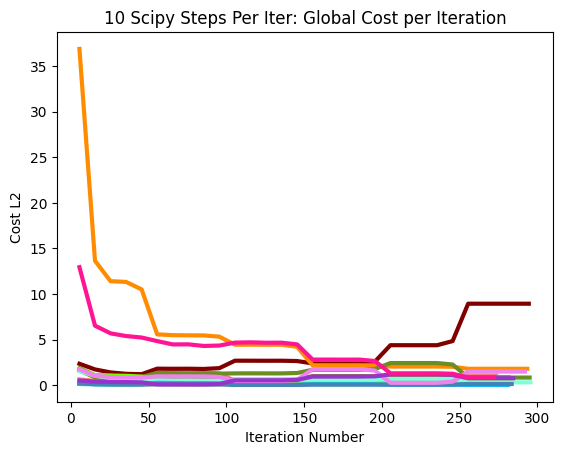

In [40]:
dim_reduc_factor = 10

for i in range(num_participants):
    #if i in (1, 3, 13):
    #    pass
    #else:
    df_global_error = pd.DataFrame(user_c0_10scipy[i].global_error_log)
    df_global_error10 = df_global_error.groupby(df_global_error.index//dim_reduc_factor, axis=0).mean()
    plt.plot(df_global_error10.values[:, 0], df_global_error10.values[:, 1], color=id2color[i], linewidth=3)

plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('10 Scipy Steps Per Iter: Global Cost per Iteration')
plt.show()

## Full Scipy.Minimize

In [41]:
user_c0_fullscipy = [Client(i, D_0_7, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model_fullscipy = Server(4, D_0_7, 'FedAvg', user_c0_fullscipy, C=1)

for i in range(18):
    if i%np.ceil(18*.1)==0:
        print(f"Iter {i}")
    global_model_fullscipy.execute_FL_loop()
print("Complete")

#cost_array = np.zeros((num_participants,17))
#for i in range(17):
#    for (client_id, error) in global_model_no_fl.local_error_log[i]:
#        cost_array[client_id, i] = error

Iter 0
Iter 2
Iter 4
Iter 6
Iter 8
Iter 10
Iter 12
Iter 14
Iter 16
Complete


Local

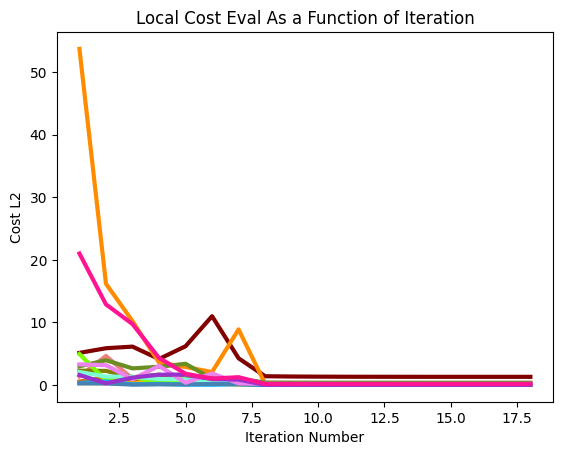

In [42]:
for i in range(num_participants):
    df = pd.DataFrame(user_c0_fullscipy[i].local_error_log)
    #my_indices = np.array(range(len(df.values)))
    #plt.plot(my_indices, df.values, color=id2color[i], linewidth=3)
    plt.plot(df.values[:, 0], df.values[:, 1], color=id2color[i], linewidth=3)
           
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
plt.show()

Global

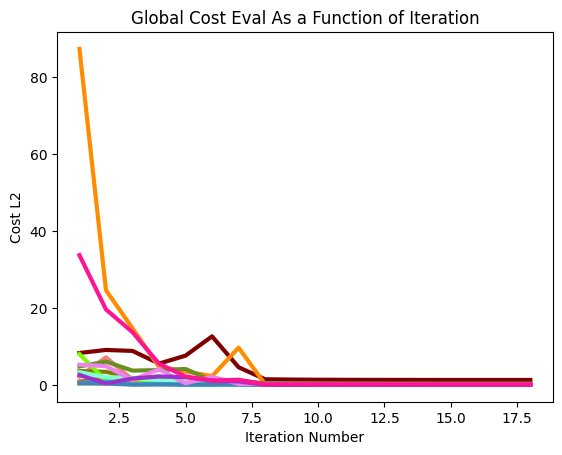

In [43]:
for i in range(num_participants):
    df = pd.DataFrame(user_c0_fullscipy[i].global_error_log)
    #my_indices = np.array(range(len(df.values)))
    #plt.plot(my_indices, df.values, color=id2color[i], linewidth=3)
    plt.plot(df.values[:, 0], df.values[:, 1], color=id2color[i], linewidth=3)
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Global Cost Eval As a Function of Iteration')
plt.show()

# Personalized FL Algorithms
ALL PERSONALIZATION ALGORITHMS
1. APFL
1. Cesar/Taha: AFL
1. Cesar/Taha: PersA-FL MAML
1. Cesar/Taha: PersA-FL ME
1. PFA: PP F Adaptation for Effective Model Personalization
1. Pers RT FL for Epileptic Seizure Detection
1. An Efficient Framework for Clustered FL
1. Pers FL with DP
## Adaptive Personalized FL Testing Ground

Adapting their code to actually be able to be run in something other than top-down server-only approach
> Their Github: https://github.com/MLOPTPSU/FedTorch <br>
> APFL link: https://github.com/MLOPTPSU/FedTorch/blob/ab8068dbc96804a5c1a8b898fd115175cfebfe75/fedtorch/comms/trainings/federated/apfl.py#L33

loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x. Loss.backward() does not update the weights, only computes the gradients.  The graph is used by loss.backward() to compute gradients.  In pseudo-code: x.grad += dloss/dx

optimizer.step updates the value of x using the gradient x.grad. For example, the SGD optimizer performs:

x += -lr * x.grad
optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.

optimizer.zero_grad() and optimizer.step() do not affect the graph of autograd objects. They only touch the model’s parameters and the parameter’s grad attributes.

If you have multiple losses (loss1, loss2) you can sum them and then call backwards once:

loss3 = loss1 + loss2
loss3.backward()

In [44]:
assert(1==0)

AssertionError: 

In [ ]:
#python run_mpi.py -f -ft apfl -n 10 -d mnist -lg 0.1 -b 50 -c 20 -k 1.0 -fs local_step -l 10 -r 2 -pa 0.5 -fp
#'--num_epochs': args.num_epochs_per_comm * args.num_comms,

# num_epochs_per_comm=1
# num_clients=20
# batch_size=50
# num_comms=100
# lr_gamma=1.0
# lr_mu = 1

cmd = 'python main.py '
for k, v in training_params.items():
    if v is not None:
        cmd += ' {} {} '.format(k, v)

Reworking their code for us <br> <br>

In [ ]:
#https://github.com/MLOPTPSU/FedTorch/blob/ab8068dbc96804a5c1a8b898fd115175cfebfe75/fedtorch/comms/trainings/federated/apfl.py#L33

def apfl_skeleton(client):
    # Number of communication rounds in federated setting should be defined
    for n_c in range(client.args.num_comms):
        client.args.rounds_comm += 1
        # Configuring the devices for this round of communication
        if client.args.graph.rank in online_clients_server: 
            if client.args.graph.rank in online_clients:
                is_sync = False
                ep = -1 # counting number of epochs
                while not is_sync:
                    ep += 1
                    for i, (_input, _target) in enumerate(client.train_loader):
                        # update local step.
                        # update local index and get local step
                        # adjust learning rate (based on the # of accessed samples)
                        # load data
                        # Skip batches with one sample because of BatchNorm issue in some models!
                        # inference and get current performance.
                        # compute gradient and do local SGD step.
                        # compute gradient and do local SGD step.
                        # update alpha
                        # reset load time for the tracker.
            # Sync the model server based on model_clients
            # evaluate the sync time
            # Do the validation on the server model
            # logging.
            # reset start round time.
            # validate the models at the test data
            
################################################################################################

def train_and_validate_federated_apfl():
    #if client.args.evaluate and client.args.graph.rank==0:
    #    # Do the testing on the server and return
    #    do_validate(client.args, client.model, client.optimizer,  client.criterion, client.metrics, client.test_loader, client.all_clients_group, data_mode='test')
    #    return
    
    tracker = define_local_training_tracker()
    start_global_time = time.time()
    tracker['start_load_time'] = time.time()

    # Number of communication rounds in federated setting should be defined
    # IN THIS CASE, WE NUM_COMMS IS NUM ROUNDS BUT WE COUNT UNAVAILABILITY FOR A ROUND AS A COMM
    # How to change this to the case where the global model controls but the local nodes have their own number of comm rounds?
    # For now I think it's easiest to just use a single shared global num_comms
    for n_c in range(self.num_comms):
        self.current_round += 1
        self.comm_time.append(0.0)  # NEED TO ADD THIS
        # Configuring the devices for this round of communication
        self.set_available_clients_list()
        self.choose_clients()
        # Idk what this is doing, I'm assuming just choosing clients
        #if (n_c == 0) and (0 not in online_clients):
        #    online_clients += [0]
        #online_clients_server = online_clients if 0 in online_clients else online_clients + [0]
        #online_clients_group = dist.new_group(online_clients_server)
        
        # Idk what all this graph rank stuff is
        #if client.args.graph.rank in online_clients_server: 
        for my_client in self.chosen_clients_lst:
            #client.model_server = distribute_model_server(client.model_server, online_clients_group, src=0)
            # This is what the above line does, broadcasts params to the client model... what params?
            #    for server_param in model_server.parameters():
            #          dist.broadcast(server_param.data, src=src, group=group)
            #my_client. ?? recieve new global model? Other params?
            # Maybe I could combine these into a dictionary to pass down instead of doing this manually
            my_client.global_method = self.method
            my_client.global_w = self.w
            
            # Now load condition num for us I think, or general client init stuff
            #client.model.load_state_dict(client.model_server.state_dict())
            #
            
            #if client.args.graph.rank in online_clients:
            if True:  # Not sure how the above condition is different from my existing for loop above 
                is_sync = False
                # Client's epoch? Does it matter?
                ep = -1 # counting number of epochs
                while not is_sync:
                    ep += 1
                    #self.training_data
                    #self.labels
                    # Slice up training-data and labels using my already written code:
                    #my_client.data_stream='streaming'  # This should be set in the client inits already
                    my_client.simulate_data_stream()
                    _input = self.F
                    _target = self.V
                    
                    # What data are we looping through? Could this be our updates? I don't think we want to do all updates on 1 comm tho...
                    # Assuming this is some SGD stochastic data batch stuff
                    #for i, (_input, _target) in enumerate(client.train_loader):
                    for i in range(1):
                        my_client.train_model
                        # update local step.
                        logging_load_time(tracker)  # NEED TO ADD THIS
                        # update local index and get local step
                        # ^ How is local index different from local round?
                        
                        #client.args.local_index += 1
                        my_client.local_round += 1
                        # Yah this is some stochastic batching stuff... ask Momona if we should be doing this
                        #client.args.local_data_seen += len(_target)
                        #get_current_epoch(client.args)
                        # This code is the above function... I don't think we are doing epochs?
                        #if args.growing_batch_size:
                        #    args.epoch_ = args.local_data_seen / args.num_samples_per_epoch
                        #else:
                        #    args.epoch_ = args.local_index / args.num_batches_train_per_device_per_epoch
                        #args.epoch = int(args.epoch_)
                        
                        # I don't have a decaying learning rate yet
                        #local_step = get_current_local_step(client.args)
                        #"""Design a specific local step adjustment scheme based on lr_decay_by_epoch"""
                        #try:
                        #    return args.local_steps[args.epoch]
                        #except:
                        #    return args.local_steps[-1]
                        
                        # adjust learning rate (based on the # of accessed samples)
                        #lr = adjust_learning_rate(client.args, client.optimizer, client.scheduler)
                        # What is lr_external? The global one or a default val?
                        # Whose lr is this? The client's or the server's?
                        if lr_external is None:
                            # Don't have a scheduler since no epochs
                            lr = lr_scheduler(epoch_)
                            if lr is None:
                                lr = lr_prev
                        else:
                            lr = lr_external
                        if lr_prev != lr:
                            lr_prev = lr

                        # load data
                        # """Loads a mini-batch and records the loading time."""
                        #_input, _target = load_data_batch(client.args, _input, _target, tracker)
                        
                        # Doesn't apply to us I don't think
                        # Skip batches with one sample because of BatchNorm issue in some models!
                        #if _input.size(0)==1:
                        #    is_sync = is_sync_fed(client.args)
                        #    break
                        
                        # inference and get current performance.
                        # zero_grad just returns a deepcopy of self.model... not sure if this is different from our self.w? It sets self.grad to deepcopy(self.model)
                        # ^ Should this be self.w or the cost func?
                        # So does this even do anything then? If I did self.w = self.w... so it must be something else...
                        client.optimizer.zero_grad()
                        loss, performance = inference(client.model, client.criterion, client.metrics, _input, _target)
                        # compute gradient and do local SGD step.
                        loss.backward()
                        client.optimizer.step(apply_lr=True,apply_in_momentum=client.args.in_momentum, apply_out_momentum=False)
                        client.optimizer.zero_grad()
                        client.optimizer_personal.zero_grad()
                        loss_personal, performance_personal = inference_personal(client.model_personal, client.model, 
                                                                                 client.args.fed_personal_alpha, client.criterion, 
                                                                                 client.metrics, _input, _target)
                        # compute gradient and do local SGD step.
                        loss_personal.backward()
                        client.optimizer_personal.step(apply_lr=True,apply_in_momentum=client.args.in_momentum, apply_out_momentum=False)
                        # update alpha
                        if client.args.fed_adaptive_alpha and i==0 and ep==0:
                            client.args.fed_personal_alpha = alpha_update(client.model, client.model_personal, client.args.fed_personal_alpha, lr) #0.1/np.sqrt(1+args.local_index))
                            average_alpha = client.args.fed_personal_alpha
                            average_alpha = global_average(average_alpha, client.args.graph.n_nodes, group=online_clients_group)
                            log("New alpha is:{}".format(average_alpha.item()), client.args.debug)
                        # reset load time for the tracker.
                        tracker['start_load_time'] = time.time()
                        is_sync = is_sync_fed(client.args)
                        if is_sync:
                            break
            else:
                log("Offline in this round. Waiting on others to finish!", client.args.debug)

            do_validate(client.args, client.model, client.optimizer_personal, client.criterion, client.metrics, 
                        client.train_loader, online_clients_group, data_mode='train', personal=True, 
                        model_personal=client.model_personal, alpha=client.args.fed_personal_alpha)
            if client.args.fed_personal:
                do_validate(client.args, client.model, client.optimizer_personal, client.criterion, client.metrics, 
                            client.val_loader, online_clients_group, data_mode='validation', personal=True, 
                            model_personal=client.model_personal, alpha=client.args.fed_personal_alpha)

            # Sync the model server based on model_clients
            tracker['start_sync_time'] = time.time()
            client.args.global_index += 1
            client.model_server = fedavg_aggregation(client.args, client.model_server, client.model, 
                                                     online_clients_group, online_clients, client.optimizer)
            # evaluate the sync time
            logging_sync_time(tracker)
            # Do the validation on the server model
            do_validate(client.args, client.model_server, client.optimizer, client.criterion, client.metrics, 
                        client.train_loader, online_clients_group, data_mode='train')
            if client.args.fed_personal:
                do_validate(client.args, client.model_server, client.optimizer, client.criterion, client.metrics, 
                            client.val_loader, online_clients_group, data_mode='validation')
            # logging.
            logging_globally(tracker, start_global_time)
            # reset start round time.
            start_global_time = time.time()
            # validate the models at the test data
            if client.args.fed_personal_test:
                do_validate(client.args, client.model_client, client.optimizer_personal, client.criterion, 
                            client.metrics, client.test_loader, online_clients_group, data_mode='test', personal=True,
                            model_personal=client.model_personal, alpha=client.args.fed_personal_alpha)
            elif client.args.graph.rank == 0:
                do_validate(client.args, client.model_server, client.optimizer, client.criterion, 
                            client.metrics, client.test_loader, online_clients_group, data_mode='test')
        else:
            log("Offline in this round. Waiting on others to finish!", client.args.debug)
        dist.barrier(group=client.all_clients_group)            log("Offline in this round. Waiting on others to finish!", client.args.debug)
        dist.barrier(group=client.all_clients_group)

My original attempts at writing

In [ ]:
# Remember to set smoothbatch='off'

#mew strongly convex...
eta_t = 16 / (mew*(t+a))
a = np.max(128*K, Tau)
K = L/mew
p_t = (t+a)^2
S_T = np.sum(p_t)

In [ ]:
#for t in rounds:
running_dec_aggr = 0
for my_client in self.chosen_clients_lst:
    if self.current_round%self.tau!=0:  # "t not divides Tau"
        # Tau --> After Tau local updates, the global models are pushed back to the server
        # Grad is the stochastic gradient evaluated at minibatch smallChi
        
        #my_client.global_w -= my_client.eta * grad(f_i(my_client.global_w; my_client.smallChi))
        my_client.global_w -= my_client.eta * my_client.gradient_cost_l2(my_client.F, my_client.D, my_client.H, my_client.V, my_client.learning_batch, my_client.alphaF, my_client.alphaD)
        #my_client.local_w -= my_client.eta * grad_v(f_i(my_client.v_bar; my_client.smallChi))
        my_client.local_w -= my_client.eta * my_client.gradient_cost_l2(my_client.F, my_client.D, my_client.H, my_client.V, my_client.learning_batch, my_client.alphaF, my_client.alphaD)
        my_client.v_bar = my_client.alpha*my_client.local_w - (1 - my_client.alpha) * my_client.global_w
        # Update U? Select new clients I think
    else:
        # Aggregate clients global models
        running_dec_aggr += my_client.global_w
if self.current_round%self.tau==0:
    # Eg only run this for the else case
    self.global_w = (1/U)*running_dec_aggr  # What is 1/|Ut|?  Why didn't they just use K
    # Their pseudo code says to broadcast new global_w to a new set of chosen clients
for my_client in (set(self.available_clients_lst) ^ set(self.chosen_clients_lst)):  # Symmetric Difference for sets
    # Is this supposed to be a new Ut? That wouldn't make much sense to me
    my_client.local_w = my_client.local_w
    # Does this even need to happen idk why they do this... just to advance the index or is there another reason

running_dec_aggr = 0
for my_client in self.available_clients_lst:
    running_dec_aggr += my_client.global_w
    running_pt_dec_aggr += p_t
for my_client in self.available_clients_lst:  # What is tin...
    # "Output"
    # v hat
    # What is S_T lol
    #my_client.personalized_w = (1/S_T)*
    #sum from t=1 to T of p(my_client.alpha)
    # w hat
    my_client.global_w = (1/(K*S_T))
    #self.dec_log
    
    

## Personalized Asynchronous Federated Learning (Taha+Cesar)
> https://arxiv.org/pdf/2210.01176.pdf

In [ ]:
assert(1==0)

Basic AFL
> My code is not configured to run this way, although this way is the most realistic (server waits for client responses).  Ideally would have some way to weight different clients if there are some that are spamming, or generally just faster than others and contributing more.

In [ ]:
# Repeat until converged...
# how do you know in a decentralized way lol
#if self.update_recieved:
#    self.w -= self.beta*self.latest_update

Personalized AFL
> 3 Methods (1 is just vanilla AFL)

In [ ]:
#input: number of local steps Q, local stepsize η, MAML stepsize α, Moreau Envelope (ME) regularization parameter λ, minimum batch size b, estimation error ν.

# Do client selection

for my_client in self.chosen_clients_lst:
    my_client.global_w = self.w
    for q in range(Q):
        #"Sample a data batch D_{i, q} from distribution p_i"
        
        # OPTION A (AFL) --> Just what is shown in the cell above
        if self.global_method=='AFL':
            # Server doesn't have client's grad input info... eg FDHV
            # In their model/code, does the client send the params or the new weight?
            
            # Eqn 5 is the original
            # Eqn 9 is the biased estimation of 5, shown below
            self.w -= self.eta*gradient_cost_l2(self.F,self.D,self.H,self.V,self.learning_batch,self.alphaF,self.alphaD)
        # OPTION B (PersA-FL: MAML)
        elif self.global_method=='PersA_FL_MAML':
            #"Sample 2 databatches from distribution p_i"
            # I have no idea what these terms are lol
            # I don't think I can use the analytical cost funcs here either now
            self.w -= self.eta*(I-alpha*Hessian(self.w, D_dd))*grad(self.w-alpha*grad(D_d), D)
        # OPTION C (PersA-FL: ME)
        elif self.global_method=='PersA_FL_ME':
            self.h = f(theta_i, D) + lambda*0.5*(np.linalg.norm(theta_i - self.w)^2)
            #"Minimize h wrt theta_i up to accuracy level v to find theta_tilde_i"
            #np.linalg.norm(grad_h(theta_tilde_i(self.w), self.w, D)) <= v
            #scipy.minimize(...)
            self.w -= self.eta*lambda*(self.w - theta_tilde_i(self.w))
        
        # ELSE
        else:
            print(f'Global method {self.method} not defined, please select one from the following: {self.implemented_global_training_methods}')
delta_i = self.w_i_0 - self.w_i_Q
# client i broadcasts delta_i to the server
#"Repeat until not interrupted by the server"